In [1]:
import torch

In [2]:
import numpy as np

In [3]:
from torch.utils.data import DataLoader, Subset, default_collate

In [4]:
import matplotlib.pyplot as plt

### Loading dataset

In [5]:
%run "Data loader.ipynb"

In [6]:
%run "Encoder.ipynb"

In [7]:
dataset = ImageCaptioningDatasetOnlyFeatures('./flickr30k_images/results.csv','./flickr30k_images/flickr30k_images',encoder=EncoderResnet18(), cache_file="images_vector_resnet18.pkl")

C:\Users\Y9G6NU724\anaconda3\Lib\site-packages\torch\overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
C:\Users\Y9G6NU724\anaconda3\Lib\site-packages\torch\overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
C:\Users\Y9G6NU724\anaconda3\Lib\site-packages\torch\overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
C:\Users\Y9G6NU724\anaconda3\Lib\site-packages\torch\overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


In [8]:
len(dataset.vocab)

5465

In [9]:
len(dataset)


158915

In [10]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])


In [11]:
dataset.vocab.lookup_tokens(list(dataset[52][1]))

['<START>',
 'five',
 'girls',
 'are',
 'leaping',
 'simultaneously',
 'in',
 'a',
 'dance',
 'practice',
 'room',
 '<END>']

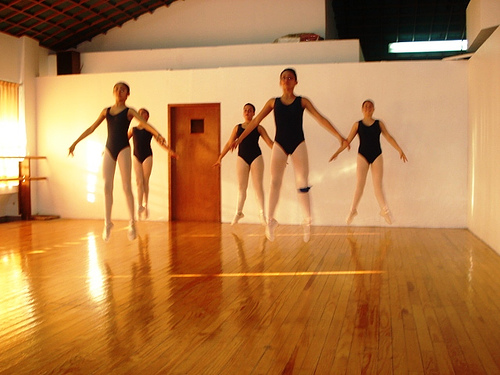

In [12]:
from PIL import Image
Image.open(dataset[52][3])

### Data splitting

Each image has 5 comments, each comment will be used independently for training, while for evaluation, 5 comments per image will be used

In [13]:
train_size = 5*(int(0.8*len(dataset))//5)
train_size

127130

In [14]:
val_size = 5*(int((len(dataset) - train_size)/2)//5)
val_size

15890

In [15]:
test_size = len(dataset) - train_size - val_size
test_size

15895

In [16]:
train_dataset = Subset(dataset, np.arange(train_size))
val_dataset = Subset(dataset, np.arange(train_size, train_size + val_size))
test_dataset = Subset(dataset, np.arange(train_size + val_size, len(dataset)))

In [17]:
print(f"Training Dataset: {len(train_dataset)}")
print(f"Validation Dataset: {len(val_dataset)}")
print(f"Testing Dataset: {len(test_dataset)}")

Training Dataset: 127130
Validation Dataset: 15890
Testing Dataset: 15895


### Data Parameter

In [18]:
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 60


In [19]:
%run Utils.ipynb
        

In [20]:
train_loader = DataLoader(train_dataset, TRAIN_BATCH_SIZE, True, collate_fn=pad_sequences)
train_loader_for_eval = DataLoader(train_dataset, VAL_BATCH_SIZE, False, collate_fn=unsorted_pad_sequences)
val_loader = DataLoader(val_dataset, VAL_BATCH_SIZE, False, collate_fn=unsorted_pad_sequences)
test_loader = DataLoader(test_dataset, VAL_BATCH_SIZE, False, collate_fn=unsorted_pad_sequences)

### Model

In [21]:
EMBEDDING_FILE = "glove.6B.200d.txt"

In [22]:
embeddings_index = {}
with open(EMBEDDING_FILE, "r",encoding="utf8") as f:
    for i,line in enumerate(f):
        values = line.split(' ')
        word = values[0] ## The first entry is the word
        if word in dataset.vocab:
            coefs = np.asarray(values[1:], dtype='float32') ## These are the vecotrs representing the embedding for the word
            embeddings_index[word] = coefs


In [23]:
len(embeddings_index.keys())

5391

In [24]:
%run Model.ipynb

In [25]:
EMBEDDING_SIZE = 200
HIDDEN_SIZE = 256
BEAM_WIDTH = 5
VOCAB_SIZE = len(dataset.vocab)
FEATURE_SIZE = 512

In [26]:
embedding_mat = np.array(np.random.randn(VOCAB_SIZE,EMBEDDING_SIZE),dtype=np.float32)
for token, emb in embeddings_index.items():
    embedding_mat[dataset.vocab.lookup_indices([token])[0]] = emb

In [27]:
lstm_model = DecoderPretrainedWithImageFeatureForPrediction(FEATURE_SIZE, torch.tensor(embedding_mat),HIDDEN_SIZE,VOCAB_SIZE,*dataset.vocab.lookup_indices(['<START>','<END>','<PAD>']))


In [28]:
lstm_model.cuda()

DecoderPretrainedWithImageFeatureForPrediction(
  (features_to_embedding): Linear(in_features=512, out_features=200, bias=True)
  (features_to_hidden): Linear(in_features=512, out_features=256, bias=True)
  (embedding): Embedding(5465, 200)
  (lstm): LSTM(200, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=5465, bias=True)
)

### Evaluation metric

In [29]:
padding_token = dataset.vocab.lookup_indices(['<PAD>'])[0]

In [30]:
from torchtext.data.metrics import bleu_score
def evaluate(loader, sample_amount=0.02):
    lstm_model.eval()
    lstm_model.prepare_for_prediction(3)
    cross_entropy_score = 0
    bleu_score_ = 0
    batch_count = 0
    sample_op = {'actual':[], 'predicted':[]}
    
    with torch.no_grad():
        for features, captions, caption_length in tqdm(loader):
            batch_size = features.shape[0]
            scores, pred_captions,pred_lengths = lstm_model.predict(features)
            scores = scores.permute(0,2,1)
            captions = captions.type(torch.LongTensor).cuda()
            min_size = min(scores.shape[2],captions.shape[1])
            cross_entropy = criterion_cross_ent(scores[:,:,:min_size], captions[:,:min_size])
            
            unique_preds_idx = ([True, False, False, False, False]*(batch_size//5))
            unique_preds = pred_captions[unique_preds_idx][:,1:]
            unique_preds = nn.utils.rnn.unpad_sequence(torch.tensor(unique_preds),pred_lengths[unique_preds_idx] - 2, batch_first=True)
            unique_preds = convert_pred_to_str(unique_preds)
            
            captions = nn.utils.rnn.unpad_sequence(captions[:,1:], caption_length - 2, batch_first=True)
            captions = convert_pred_to_str(captions)
            captions_reshaped = [ captions[5*i:5*i+5] for i in range(batch_size//5)]
            try:
                bleu_score_per_batch = bleu_score(unique_preds, captions_reshaped)
                bleu_score_ += bleu_score_per_batch
                batch_count += 1
                cross_entropy_score += cross_entropy
            except:
                print("Exception")


                
            if np.random.rand() > 1-sample_amount:
                sample_op['predicted'].append(' '.join(unique_preds[batch_size//7]))
                sample_op['actual'].append(' '.join(captions_reshaped[batch_size//7][0]))
                
    return bleu_score_/batch_count, cross_entropy_score/batch_count, sample_op
            

In [31]:
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
writer = SummaryWriter('runs/lstm_decoder0')
iter_= 0
pd.set_option('max_colwidth', 1000)

### Training parameters

In [32]:
EPOCH = 10
LR = 0.005

### Loss function for training 

In [33]:
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=LR, betas=(0.8, 0.999))

In [34]:
criterion_cross_ent = nn.CrossEntropyLoss(ignore_index=padding_token)

In [35]:
for epoch in range(EPOCH):
    print(f"Epoch {epoch}:")
    cross_entropy_epoch = 0
    num_batches = 0
    lstm_model.train()
    for features, captions, caption_length in tqdm(train_loader):
        batch_size = features.shape[0]
        optimizer.zero_grad()
        scores = lstm_model(features,captions, caption_length)
        cross_entropy_loss = criterion_cross_ent(scores.permute(0,2,1), captions.type(torch.LongTensor).cuda())
        #backprop
        cross_entropy_loss.backward()
        optimizer.step()
        iter_ += 1
        num_batches += 1
        if iter_%500 == 0:
            writer.add_scalar('Train cross entropy', cross_entropy_loss.item(),global_step=iter_)
            writer.add_scalar('Accuracy', ((scores.argmax(-1) == captions).sum())/(batch_size*scores.shape[1]), global_step=iter_)
        cross_entropy_epoch += cross_entropy_loss.item()
    print("Sample output from training dataset")
    pred_0 = scores[0].argmax(1)
    pred_str = ' '.join(convert_pred_to_str(pred_0))
    print("actual caption",' '.join(convert_pred_to_str(captions[0])))
    print("predicted caption", pred_str)
    print(f"Train Cross entropy {cross_entropy_epoch/num_batches :.4f}")
    
    val_bleu_score, val_cross_entropy, sample_op = evaluate(val_loader)
    print(f"Validation Bleu score: {val_bleu_score}, Validation Cross Entropy: {val_cross_entropy}")
    display(pd.DataFrame(sample_op))
    if epoch%2 == 0:
        train_bleu_score, train_cross_entropy, sample_op = evaluate(train_loader_for_eval)
        print(f"Train Bleu score: {train_bleu_score}, Train Cross Entropy: {train_cross_entropy}")
        display(pd.DataFrame(sample_op))
    print("--------------------------------------")

Epoch 0:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1987/1987 [01:00<00:00, 32.63it/s]


Sample output from training dataset
actual caption <START> a young boy with flour on his nose and cheeks is dressed in overalls and an apron has his hands in a bowl while he smiles for the camera <END>
predicted caption <START> a man boy is a is his head <END> a <END> standing in a <END> a orange <END> a hands in the kitchen <END> a reads <END> the camera <END>
Train Cross entropy 3.0543


  0%|                                                                                                                                     | 0/265 [00:00<?, ?it/s]C:\Users\Y9G6NU724\AppData\Local\Temp\ipykernel_4104\3975644972.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unique_preds = nn.utils.rnn.unpad_sequence(torch.tensor(unique_preds),pred_lengths[unique_preds_idx] - 2, batch_first=True)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:17<00:00, 14.95it/s]

Validation Bleu score: 0.11600922138667559, Validation Cross Entropy: 7.161323070526123


,actual,predicted
0,an asian wearing a pastel print shirt and sunhat pushing his cart up the street,a woman in a black jacket is standing next to a large tree
1,two men in all black practice a fighting sport with sticks while a man in a blue shirt looks on,a man in a blue shirt is standing on a balcony
2,a is swinging a bat at a baseball during a game while the catcher and umpire look on,a man in a blue shirt is kicking a soccer ball
3,a crowd behind a fence is watching bicyclists ride up a hilly road with motorcycles behind them,a group of people are gathered around a table with a group of people in the background
4,a man wearing a striped shirt and a woman holding a bouquet of purple flowers are kissing as a takes their picture,a woman in a black shirt is sitting on a stool eating


  0%|                                                                                                                                    | 0/2119 [00:00<?, ?it/s]C:\Users\Y9G6NU724\AppData\Local\Temp\ipykernel_4104\3975644972.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unique_preds = nn.utils.rnn.unpad_sequence(torch.tensor(unique_preds),pred_lengths[unique_preds_idx] - 2, batch_first=True)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2119/2119 [02:28<00:00, 14.26it/s]

Train Bleu score: 0.12779332473740324, Train Cross Entropy: 6.9349565505981445


,actual,predicted
0,a young boy is falling into a pool of water with a man and a girl watching him,a young girl in a blue shirt is walking down the beach
1,two men in hard hats on the roof of a building that is under construction,a man in a blue shirt is walking down a street
2,a construction worker in a yellow vest digs in the street while a second worker looks on,a man in a blue shirt is sitting on a stool and a woman in a blue shirt
3,a young man in shorts and a polo shirt is carrying a garbage bag out of an empty lot with another man following him,a young girl in a pink shirt is standing on a sidewalk
4,a man with a black helmet on smokes a cigarette while he drives his motorcycle in traffic,a man in a blue shirt is standing next to a car
5,a man in green holding a camera stands between two of the head statues on easter island,a man in a blue shirt is standing in front of a large rock wall
6,several children are playing a basketball game on a basketball court,a young girl in a blue shirt is playing tennis
7,three painters in all white are painting over a building covered in red and black graffiti,a man in a blue shirt is standing next to a woman in a white shirt and a woman in a white shirt
8,a young girl wearing a yellow shirt with a blue backpack is walking next to a fence covered with a blue plastic cover,a woman in a blue shirt is walking down a sidewalk
9,a man in a white tshirt takes a picture in the middle of the street with two public buses in the background,a woman in a blue shirt is walking down a street


--------------------------------------
Epoch 1:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1987/1987 [01:00<00:00, 32.61it/s]


Sample output from training dataset
actual caption <START> a colored man and a young blond   both dressed in jeans and maroon tshirts   carry a banner which reads    workers say stop black in   <END>
predicted caption <START> a man man in a woman boy girl both are in black   black tshirts   are a sign <END> is       stop to     <END>
Train Cross entropy 2.7253


  0%|                                                                                                                                     | 0/265 [00:00<?, ?it/s]C:\Users\Y9G6NU724\AppData\Local\Temp\ipykernel_4104\3975644972.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unique_preds = nn.utils.rnn.unpad_sequence(torch.tensor(unique_preds),pred_lengths[unique_preds_idx] - 2, batch_first=True)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:20<00:00, 13.19it/s]

Validation Bleu score: 0.10990155333763779, Validation Cross Entropy: 7.423392295837402


,actual,predicted
0,a group of young asian women is walking down the street they re wearing colorful clothes and fans and it looks like they re marching in a parade,a group of people are gathered in a park
1,in what appears to be a college a group of students are sitting on the steps some are using technology and others are just relaxing and socializing,a man in a blue shirt and jeans is sitting on a chair with a blue cooler on it
2,four children two boys and two girls play on a green lawn with a tree and a building in the background,a man in a blue shirt and jeans is playing tennis
3,a large group of students are taking a break from school and are having lunch together,a group of people are sitting on a bench in a park


--------------------------------------
Epoch 2:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1987/1987 [01:00<00:00, 32.84it/s]


Sample output from training dataset
actual caption <START> a man in all black is playing the violin outdoors and has the attention of a young woman who is sitting in front him   enjoying the performance <END>
predicted caption <START> a man in a black is standing a drums <END> <END> a a word of the woman woman <END> is wearing in front of <END> and a movement <END>
Train Cross entropy 2.6285


  0%|                                                                                                                                     | 0/265 [00:00<?, ?it/s]C:\Users\Y9G6NU724\AppData\Local\Temp\ipykernel_4104\3975644972.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unique_preds = nn.utils.rnn.unpad_sequence(torch.tensor(unique_preds),pred_lengths[unique_preds_idx] - 2, batch_first=True)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:17<00:00, 14.88it/s]

Validation Bleu score: 0.1182252852978747, Validation Cross Entropy: 7.420388221740723


,actual,predicted
0,young woman in black leather jacket with long redhair outside and putting on makeup,a woman in a pink shirt is holding a camera
1,a man wearing a tan tshirt with a car on it and blue jeans holds a knife in his left hand while he prepares to throw another knife with his right hand,a man in a black shirt and black pants is standing in front of a microphone
2,a man wearing a green shirt blue jeans shades and a cap is cooking on the grill as people in the background wait to get some food,a man in a blue shirt is standing in front of a large crowd of people
3,two children lay under a sculpture of a fish about to them,a woman in a blue shirt is lying on a bed
4,an older man wearing a bowler hat and white gloves is playing a tuba with fire blowing out of the top while sitting on a box amplifier in front of a cement wall,a man in a red shirt and black pants is playing a saxophone


  0%|                                                                                                                                    | 0/2119 [00:00<?, ?it/s]C:\Users\Y9G6NU724\AppData\Local\Temp\ipykernel_4104\3975644972.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unique_preds = nn.utils.rnn.unpad_sequence(torch.tensor(unique_preds),pred_lengths[unique_preds_idx] - 2, batch_first=True)
 24%|█████████████████████████████▌                                                                                            | 514/2119 [00:34<01:48, 14.84it/s]

Exception


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1720/2119 [01:54<00:27, 14.65it/s]

Exception


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2119/2119 [02:22<00:00, 14.87it/s]

Train Bleu score: 0.135724786436284, Train Cross Entropy: 7.149960994720459


,actual,predicted
0,a band is playing in front of an audience and the singer is wearing an orange shirt and has tattoos on his arm,a man in a black shirt and black pants is playing a guitar
1,a kid wearing a gap hat looks into the camera with a funny face and ice cream cone in his hand while a woman looks on from behind him,a man in a black shirt and black hat is holding a camera
2,a young boy running with a boogie board into the water,a man in a blue shirt is jumping into the water
3,the 4 guys were rollerskating and a line in the outdoor rink with many other people on the sunny day,a man in a blue shirt and black pants is standing in front of a crowd
4,three people in various of swimming race along colorful lane markers,a young boy in a red shirt is sliding down a slide
5,a person in a green jacket and black pants lifts a rock,a man in a blue shirt is standing in a field
6,middleaged female wearing a white sunhat and white jacket her hand inside a man s pants pocket,a man in a white shirt and black hat is sitting on a bench
7,this girl has got some skills and is showing them off by playing with fire,a man in a white shirt and black pants is holding a torch in front of a crowd
8,a woman rises up from her seat and looks upward as another woman looks on with a smile on her face,a woman in a pink dress is talking to a woman in a pink shirt
9,a child in a red coat is holding an of snow in front of a house,a woman in a pink coat is sitting on a red couch


--------------------------------------
Epoch 3:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1987/1987 [01:01<00:00, 32.49it/s]


Sample output from training dataset
actual caption <START> a man dressed in protective gear walking along a stream with another man close behind him <END>
predicted caption <START> a man in in a gear is down a river <END> a man in by him <END>
Train Cross entropy 2.5665


  0%|                                                                                                                                     | 0/265 [00:00<?, ?it/s]C:\Users\Y9G6NU724\AppData\Local\Temp\ipykernel_4104\3975644972.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unique_preds = nn.utils.rnn.unpad_sequence(torch.tensor(unique_preds),pred_lengths[unique_preds_idx] - 2, batch_first=True)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:16<00:00, 15.64it/s]

Validation Bleu score: 0.13055086127446033, Validation Cross Entropy: 7.415459632873535


,actual,predicted
0,a shorthaired middleaged woman is walking on a city sidewalk passing a building with mirrored windows,a man in a black shirt and blue jeans is walking down a street
1,a boy swings at a pinata at a backyard party in the,a group of children playing soccer
2,a man wearing a pilot uniform is bending over towards a suitcase outside of a set of steps leading into a plane,a man in a black shirt is standing in front of a large crowd of people
3,a professional woman wearing a tan uniform as she looks up and smiles while having a high tech microscope in front of her,a man in a black shirt is standing in front of a microphone
4,a child in a green hat swings on monkey bars at a blue playground,a man in a blue shirt is standing in front of a building


--------------------------------------
Epoch 4:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1987/1987 [01:00<00:00, 32.61it/s]


Sample output from training dataset
actual caption <START> a young woman and older woman wear traditional saris as they spin   three people are pictured at only the   and wear modern clothes <END>
predicted caption <START> a woman boy in a man are mickey clothing and they play on one of are sitting <END> a a of one one <END> clothing <END>
Train Cross entropy 2.5191


  0%|                                                                                                                                     | 0/265 [00:00<?, ?it/s]C:\Users\Y9G6NU724\AppData\Local\Temp\ipykernel_4104\3975644972.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unique_preds = nn.utils.rnn.unpad_sequence(torch.tensor(unique_preds),pred_lengths[unique_preds_idx] - 2, batch_first=True)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:20<00:00, 13.18it/s]

Validation Bleu score: 0.11103049672161758, Validation Cross Entropy: 7.741390705108643


,actual,predicted
0,a man is painting a mural along the entrance to an underground garage,a man in a black shirt and jeans is standing in front of a building
1,a young woman dressed for the cold and wearing snowshoes sleds on a snowy day,a man in a black jacket is shoveling snow
2,a man wearing traditional garb is riding a white and black horse while holding a drum,a man in a black shirt and jeans is holding a large trophy
3,three men one in a white shirt one in a green shirt and one in a tan jacket are walking down the street the man with the tan jacket and the man with the green shirt are carrying supplies,a man in a black shirt and jeans is standing in front of a building


  0%|                                                                                                                                    | 0/2119 [00:00<?, ?it/s]C:\Users\Y9G6NU724\AppData\Local\Temp\ipykernel_4104\3975644972.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unique_preds = nn.utils.rnn.unpad_sequence(torch.tensor(unique_preds),pred_lengths[unique_preds_idx] - 2, batch_first=True)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2119/2119 [02:44<00:00, 12.88it/s]

Train Bleu score: 0.12188466185233127, Train Cross Entropy: 7.4438652992248535


,actual,predicted
0,smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him,a man in a black shirt and a woman in a black jacket are walking down a street
1,a woman with a white shirt aims a dart at an offcamera target as several other people holding darts look on beside her,a woman in a white dress and a man in a white shirt are dancing
2,three people in various of swimming race along colorful lane markers,a child in a red jacket is playing in the water
3,two men are standing in the middle of the room three more are sitting each holding a wrapped up box,a woman in a white dress and a man in a black shirt are sitting on a bench
4,a child wearing a red and gray shirt is standing in front of a chalkboard,a young boy in a red shirt is holding a yellow scrubbing brush up to his mouth
5,a man with a hat glasses jewelry and a jacket stands against an orange wall,a man in a black shirt and black bowtie is standing in front of a microphone
6,the rock climbers are on their equipment in front of a cave,a man in a red shirt is standing in front of a mountain
7,a large group of football players sitting on a field wearing red and white jerseys,a man in a red shirt and a woman in a red shirt are playing a game
8,performers dressed in and are dancing with speakers in the background,a man in a black shirt and jeans is standing in front of a large crowd
9,the man in the blue shirt wearing a guards the entrance to the elevator with the theme,a man in a black shirt and jeans is standing on a sidewalk


--------------------------------------
Epoch 5:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1987/1987 [01:00<00:00, 32.97it/s]


Sample output from training dataset
actual caption <START> square dancers out in green and white attire circle around on a tiled patio with arches and palm trees in the background <END>
predicted caption <START> a dancers are of a and white robes <END> in a a park floor <END> a and pillars trees <END> the background <END>
Train Cross entropy 2.4799


  0%|                                                                                                                                     | 0/265 [00:00<?, ?it/s]C:\Users\Y9G6NU724\AppData\Local\Temp\ipykernel_4104\3975644972.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unique_preds = nn.utils.rnn.unpad_sequence(torch.tensor(unique_preds),pred_lengths[unique_preds_idx] - 2, batch_first=True)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:19<00:00, 13.83it/s]

Validation Bleu score: 0.11622527311589814, Validation Cross Entropy: 7.695668697357178


,actual,predicted
0,the lined wall surrounding a bench where a man with a laptop sits,a man in a white shirt is standing in front of a building
1,a man and women dance together while a crowd looks on on a wooden surface,a man in a white shirt and black pants is playing a game
2,young girls line up across each other and a pingpong table in a gymnasium while a few boys on a table further back,a man in a white shirt and blue jeans is standing in front of a blue wall
3,an elderly woman in front of a fruit stand touching a package of strawberries,a man in a green shirt is selling fruit
4,a woman in a striped shirt jumps up in the air and extends her arms while leading a group of children and adults along a dirt trail,a group of people are standing in front of a large body of water


--------------------------------------
Epoch 6:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1987/1987 [01:00<00:00, 32.63it/s]


Sample output from training dataset
actual caption <START> a woman in a multicolored dress is holding a plastic cup while gesturing with the other hand <END>
predicted caption <START> a woman in a red dress and dancing a bouquet bag <END> a <END> another other man <END>
Train Cross entropy 2.4499


  0%|                                                                                                                                     | 0/265 [00:00<?, ?it/s]C:\Users\Y9G6NU724\AppData\Local\Temp\ipykernel_4104\3975644972.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unique_preds = nn.utils.rnn.unpad_sequence(torch.tensor(unique_preds),pred_lengths[unique_preds_idx] - 2, batch_first=True)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:18<00:00, 14.66it/s]

Validation Bleu score: 0.11924246965155048, Validation Cross Entropy: 7.672338962554932


,actual,predicted
0,three girls and one boy are holding onto a raft as they are being pulled by a road through the water,a man in a red jacket is playing the waves
1,a large white boat is on the ocean with several people inside,a man in a blue shirt is riding a red and white boat
2,a boy wearing a red shirt and jeans is doing a flip on his bike,a man in a red shirt is riding a bike


  0%|                                                                                                                                    | 0/2119 [00:00<?, ?it/s]C:\Users\Y9G6NU724\AppData\Local\Temp\ipykernel_4104\3975644972.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unique_preds = nn.utils.rnn.unpad_sequence(torch.tensor(unique_preds),pred_lengths[unique_preds_idx] - 2, batch_first=True)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2119/2119 [02:36<00:00, 13.58it/s]

Train Bleu score: 0.13161486398230957, Train Cross Entropy: 7.375607013702393


,actual,predicted
0,three male figures of different ages stand next to some rocks as they are by a large upright wooden cross,a man in a blue shirt and jeans is standing in front of a building
1,three boys in baggy bathing suits play in splashing water in front of a gray block wall,a woman in a red shirt and a man in a black shirt are dancing
2,the man is dancing with a doll wearing a red dress and heels,a man in a red shirt and blue jeans is walking down the street
3,a man laughs as his picture is taken in a restaurant,a man in a red shirt is sitting on a red chair
4,the brown dog is jumping over a low rail in a grassy yard,a dog runs through the grass
5,a small child wearing the colors of the american flag is shoveling snow from the front steps,a man in a red jacket is walking down the street
6,a is laying on the ground between the and the ball,a man in a red shirt is standing in front of a large crowd
7,two little girls are sleeping on the couch laying on a large man,a woman in a red shirt is sitting on a chair
8,two gray puppies are chewing on a plastic red toy,a dog is running through the grass
9,a dog is jumping in the air in a field of grass,a dog runs through the grass


--------------------------------------
Epoch 7:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1987/1987 [01:01<00:00, 32.06it/s]


Sample output from training dataset
actual caption <START> a person in a green jacket throws a stick into the water for a black and white dog to fetch whilst a brown and white dog looks on <END>
predicted caption <START> a man in a red shirt is a stick for the air <END> a picture dog white dog <END> fetch <END> a man dog white dog looks on <END>
Train Cross entropy 2.4310


  0%|                                                                                                                                     | 0/265 [00:00<?, ?it/s]C:\Users\Y9G6NU724\AppData\Local\Temp\ipykernel_4104\3975644972.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unique_preds = nn.utils.rnn.unpad_sequence(torch.tensor(unique_preds),pred_lengths[unique_preds_idx] - 2, batch_first=True)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:18<00:00, 14.17it/s]

Validation Bleu score: 0.12032872583740271, Validation Cross Entropy: 7.7055983543396


,actual,predicted
0,a woman stands on a street corner with a blue building and alley behind her,a man in a blue shirt is sitting on a bench
1,a young girl aged 3 to 5 walking down a path in what appears to be a park on a sunny day holding a doll in her left hand and a little pink pony in a handbag in her right hand,a young girl in a pink shirt is running on the grass
2,two men dressed in winter coats are standing outside in the snow in a picnic shelter getting ready to eat,a man in a black shirt and black pants is standing in front of a group of people
3,a woman dressed in blue sweeps a brick walkway near a step ladder on a city street,a man in a black shirt and jeans is walking down the street
4,a man in a white shirt standing behind an assortment of meat,a man in a black shirt is standing in front of a store
5,a dog gives a dog a haircut using electric hair,a man in a black shirt and jeans is sitting on a chair in front of a group of people
6,a crowd behind a fence is watching bicyclists ride up a hilly road with motorcycles behind them,a group of people are sitting on a bench
7,man up his back bicycle tire and hoping it will hold,a man in a red shirt is sitting on a bench
8,a child in a green hat swings on monkey bars at a blue playground,a man in a blue shirt is standing in front of a building


--------------------------------------
Epoch 8:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1987/1987 [01:01<00:00, 32.24it/s]


Sample output from training dataset
actual caption <START> a man in a black sweater and black cap sits outside a shop reading a book with a magnifying glass <END>
predicted caption <START> a man in a black shirt is jeans hat is on a restaurant <END> a newspaper <END> a woman glass <END>
Train Cross entropy 2.4094


  0%|                                                                                                                                     | 0/265 [00:00<?, ?it/s]C:\Users\Y9G6NU724\AppData\Local\Temp\ipykernel_4104\3975644972.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unique_preds = nn.utils.rnn.unpad_sequence(torch.tensor(unique_preds),pred_lengths[unique_preds_idx] - 2, batch_first=True)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:21<00:00, 12.54it/s]

Validation Bleu score: 0.11329183464935395, Validation Cross Entropy: 7.864846706390381


,actual,predicted
0,a musician performing during the world event concert held in a local church in the city of angels,a man in a black shirt and black pants is sitting on a bench
1,two soldiers at an event center are watching a woman in a red shirt do push ups while another soldier leans over here,a man in a black shirt and black pants is standing in front of a crowd
2,a professional woman wearing a tan uniform as she looks up and smiles while having a high tech microscope in front of her,a man in a blue shirt is looking at a computer screen
3,a man is standing in the aisle of a grocery store and staring at the cereal selection,a man in a blue shirt and a woman in a black shirt are walking down the street
4,an older man sits at a clean shiny desk and faces his computer screen his hands are both on the keyboard and he is intensely focused,a man is sitting on a chair looking at a computer screen
5,a girl is skipping across the road in front of a white truck,a young boy in a blue shirt and shorts is jumping in the air while another boy in a blue shirt runs towards him
6,a girl wearing a baseball cap white tshirt and blue shorts is standing in a mountain stream,a man in a blue shirt and shorts is standing in the water
7,man in purple shorts and shirt is running in a race with onlookers located to his right,a group of children are playing soccer
8,three men one in a white shirt one in a green shirt and one in a tan jacket are walking down the street the man with the tan jacket and the man with the green shirt are carrying supplies,a man in a black shirt and black pants is walking down the street


  0%|                                                                                                                                    | 0/2119 [00:00<?, ?it/s]C:\Users\Y9G6NU724\AppData\Local\Temp\ipykernel_4104\3975644972.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unique_preds = nn.utils.rnn.unpad_sequence(torch.tensor(unique_preds),pred_lengths[unique_preds_idx] - 2, batch_first=True)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2119/2119 [02:39<00:00, 13.26it/s]

Train Bleu score: 0.1252119003756707, Train Cross Entropy: 7.540687561035156


,actual,predicted
0,four individuals two males and two females sitting on the concrete steps outside of a brick building,a woman in a blue dress is standing in front of a group of children
1,two men in hard hats and work coveralls look at the docked ship one of them points at,a man in a blue shirt and a woman in a black shirt are walking down the street
2,a person stands on the top of a cliff as another attempts to climb it,a group of people are standing on a bridge
3,a young woman in sweatpants looks behind her while standing near the public toilets,a man in a blue shirt is standing in front of a building
4,this appears to be a muslim woman with her legs in a hole,a man in a blue shirt and blue jeans is standing on a rock
5,a blue rally car pulls away from the spectators watching from the side of the track,a group of people are standing on a bridge
6,two asian cheerleaders are facing forward waving silver pompoms whilst other cheerleaders are performing facing the other way,a man in a black shirt and black shorts is looking at a woman in a black shirt and a woman in a black shirt
7,a man in a black sweater sits at a desk typing on a computer keyboard,a man is sitting on a chair rubbing his eye
8,a guy with sunglasses is sitting on a boat ferry in the sun,a man in a black shirt and black pants is standing in front of a microphone
9,a tiny little girl wearing pink stands by a man who is wearing brown and sitting down,a man in a white shirt and blue shorts is standing in front of a building


--------------------------------------
Epoch 9:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1987/1987 [01:01<00:00, 32.13it/s]


Sample output from training dataset
actual caption <START> a woman with white hair in a yellow shirt lies in the grass overlooking the ocean in which a lone sailboat is visible <END>
predicted caption <START> a man in a hair is a field shirt is on the sand with a water <END> the is man person <END> by in
Train Cross entropy 2.3932


  0%|                                                                                                                                     | 0/265 [00:00<?, ?it/s]C:\Users\Y9G6NU724\AppData\Local\Temp\ipykernel_4104\3975644972.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  unique_preds = nn.utils.rnn.unpad_sequence(torch.tensor(unique_preds),pred_lengths[unique_preds_idx] - 2, batch_first=True)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 264/265 [00:19<00:00, 13.73it/s]

Exception


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 265/265 [00:19<00:00, 13.79it/s]

Validation Bleu score: 0.11419933306210941, Validation Cross Entropy: 7.758332252502441


,actual,predicted
0,young woman in black leather jacket with long redhair outside and putting on makeup,a woman in a blue shirt is holding a cigarette
1,a standing old woman helping a lying down young boy to write in a notebook,a man in a red shirt is sitting on a bench
2,a balding man wearing a striped sweater and blue jeans is writing some scores with white chalk which includes the words and which both have 5 points on a chalkboard,a man in a black shirt is standing in a doorway
3,a young man in shorts and tank top sitting on a bike with a double seat pull behind two wheeler attached to it and one in front with both being yellow in color,a man in a red shirt is riding a bicycle on a busy street


--------------------------------------


In [ ]:
evaluate(test_loader)

In [ ]:
torch.save(lstm_model.state_dict(), "lstm_decoder.pt")

In [ ]:
import pickle
with open('images_vector_resnet18.pkl', 'wb') as f:
    pickle.dump(dataset.images_features,f)